In this code, we look at the nonlinear pendulum and try to fit the data that comes from it with the linear pendulum. To make the approximation better, we keep the frequency of the linear pendulum in the PINN as a learnable parameter. That way, the PINN will learn a linear version of the physics, but with a period that matches the nonlinear physics based on the given data 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.ticker as ticker
from scipy.special import ellipk


In [2]:
torch.manual_seed(125)

from pathlib import Path
# Create used directories
directories = ["plots"]
for d in directories:
    plots_dir = Path(d)
    plots_dir.mkdir(exist_ok=True)
    print(f"Directory '{plots_dir}' is present. ✅")

Directory 'plots' is present. ✅


## Generate training data

In [29]:
X0 = [1, 0]
f  = 1
w0 = np.pi*2*f

SHO_Period = w0 / (2*np.pi)
NP_Period  = 4/w0 * ellipk(np.sin(X0[0]/2)**2)

In [30]:
print(f'SHO Period: {SHO_Period:.4f}')
print(f'NP  Period: {NP_Period:.4f}')

SHO Period: 1.0000
NP  Period: 1.0663


In [31]:
# Parameters and initial conditions

# time domain
ti,tf = 0, 3
N  = 10_000

t = torch.linspace(ti, tf, N).view(-1,1)

# Numerical Solution

def ODE(X, t):
    dXdt = [X[1], -(w0**2)*np.sin(X[0])]
    return dXdt

def ODE_2(X, t):
    dXdt = [X[1], -(w0**2)*X[0]]
    return dXdt

# Nonlinear Pendulum Solution
solution = torch.from_numpy(odeint(ODE, X0, t.numpy().flatten())).view(-1,2)
x1       = solution[:,0]
x2       = solution[:,1]
x1_max   = torch.abs(x1).max().item()
x2_max   = torch.abs(x2).max().item()

# Harmonic Oscillator Solution
solution2 = torch.from_numpy(odeint(ODE_2, X0, t.numpy().flatten())).view(-1,2)
y1        = solution2[:,0]
y2        = solution2[:,1]
y1_max    = torch.abs(x1).max().item()
y2_max    = torch.abs(x2).max().item()

# solution.dtype = np.double

# Pick points for training
N_training = 75
t_data     = torch.linspace(ti, 0.4*tf, N_training).view(-1,1)
training_data = solution[torch.searchsorted(t.flatten(), t_data.flatten()), :]
x1_data       = training_data[:,0].view(-1,1)
x2_data       = training_data[:,1].view(-1,1)

# Pick a few points for validation
N_validation = 200
t_val        = torch.linspace(ti*1.1, tf, N_validation).view(-1,1)
validation_data = solution[torch.searchsorted(t.flatten(), t_val.flatten()), :]
x1_val          = validation_data[:,0].view(-1,1)
x2_val          = validation_data[:,1].view(-1,1)

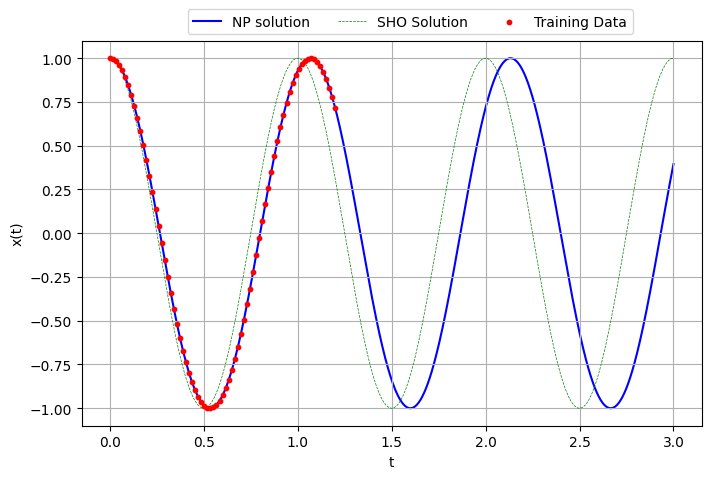

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t, x1, label='NP solution', color='blue', zorder=1)
ax.plot(t, y1, label="SHO Solution", color='green', zorder=2, linestyle='--', lw=0.5)
ax.scatter(t_data, x1_data, color='red', label='Training Data', s=10, zorder=3)
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
plt.legend(ncol=3, bbox_to_anchor=(0.9, 1.1))
plt.grid()
plt.show()

## PINN

In [33]:
def plot_result():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    
    axes[0].grid()
    axes[0].plot(t, x1, color="black", linewidth=2, alpha=1,linestyle='--',label="Nonlinear Pendulum", zorder=0)
    axes[0].plot(t, y1, color="gray", linewidth=1, alpha=1,linestyle='--',label="SHO", zorder=0)
    axes[0].plot(t, p, color="blue", linewidth=2, alpha=0.8, label="PINN prediction", zorder=1)
    axes[0].scatter(t_data, x1_data, s=15, color="red", alpha=0.4, label='Training data', zorder=2)
    axes[0].scatter(t_physics.detach(), -0*torch.ones_like(t_physics.detach()), s=10, color="green", alpha=0.4,label='Collocation points', zorder=2)
    axes[0].set_ylim(-1.05*x1_max, 1.05*x1_max)
    axes[0].set_ylabel('x(t)',fontsize="x-large")
    axes[0].set_xlabel('t',fontsize="x-large")
    axes[0].legend()
    
    axes[1].grid()
    axes[1].plot(training_loss_history, label='Training Loss', color='red', linewidth=2, zorder=1)
    axes[1].plot(validation_loss_history, label='Validation Loss', color='blue', linewidth=1.5, zorder=2, alpha=0.6)
    axes[1].plot(error_history, label='MSE', color='green', linewidth=2, zorder=3, alpha=0.5)
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, epochs)
    axes[1].set_ylim(1e-7, 1e2)
    axes[1].set_xlabel('Epochs', fontsize="x-large")
    axes[1].set_ylabel('Loss', fontsize="x-large")
    axes[1].set_title(f'MSE = {error:.3e}', fontsize="x-large")
    axes[1].legend()
    
    fig.suptitle(f"Epoch {i}", fontsize="x-large")

    plt.tight_layout()
    plt.axis("on")

In [34]:
# Define Neural Network Structure

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.scale = lambda t: (t - ti)/(tf - ti)
        self.fcs   = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        self.fch   = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce   = nn.Linear(N_HIDDEN, N_OUTPUT)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) 
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.scale(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
learning_rate = 1e-2
gamma         = 0.9
patience      = 1000
epochs        = 20_000 + 1
weights = [w_data, w_derivative, w_ode] = [1e4, 0e0, 1e0]

N_phys   = 200
N_layers = 3
N_nodes  = 64

def error(y, x):
    return torch.mean((y - x)**2)/torch.mean(x**2)

In [36]:
# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

# Define the sample locations for physics-informed training
t_physics = torch.linspace(ti, tf, N_phys).view(-1,1).requires_grad_(True)


Epoch 0: Val Loss = 1.8614e+04, period = 1.0016, NP Period = 1.0663, Learning rate = 1.0000e-02


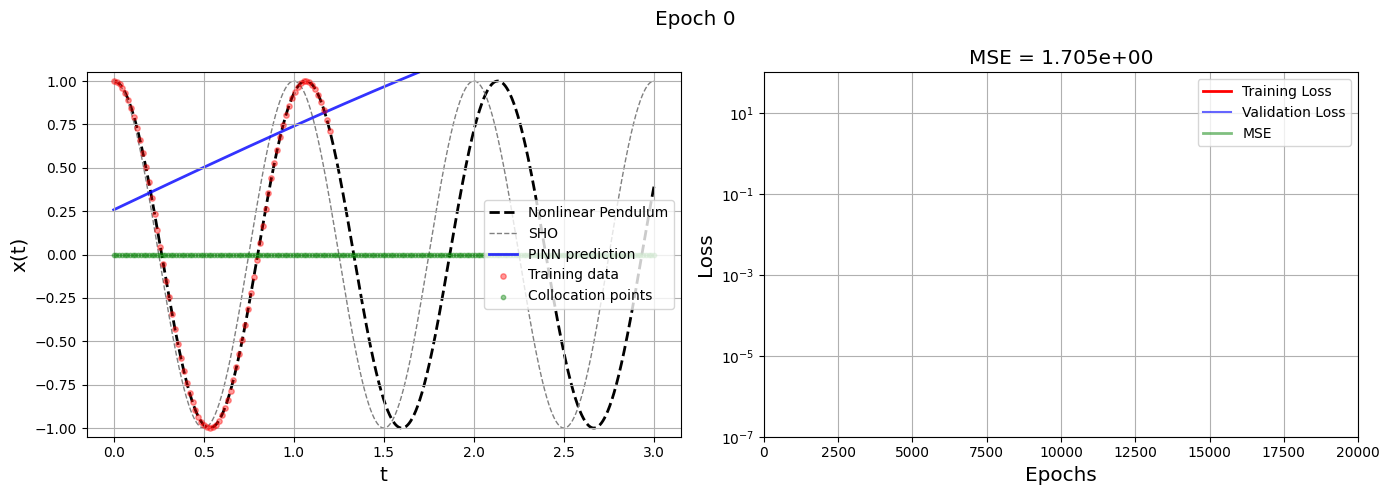

Epoch 100: Val Loss = 5.9951e+03, period = 1.0584, NP Period = 1.0663, Learning rate = 1.0000e-02
Epoch 200: Val Loss = 3.6706e+03, period = 1.1762, NP Period = 1.0663, Learning rate = 1.0000e-02
Epoch 300: Val Loss = 3.4988e+03, period = 1.2528, NP Period = 1.0663, Learning rate = 1.0000e-02
Epoch 400: Val Loss = 3.4136e+03, period = 1.2844, NP Period = 1.0663, Learning rate = 1.0000e-02
Epoch 500: Val Loss = 3.3318e+03, period = 1.2790, NP Period = 1.0663, Learning rate = 1.0000e-02
Epoch 600: Val Loss = 3.2147e+03, period = 1.2605, NP Period = 1.0663, Learning rate = 1.0000e-02
Epoch 700: Val Loss = 3.1607e+03, period = 1.2350, NP Period = 1.0663, Learning rate = 1.0000e-02
Epoch 800: Val Loss = 3.0467e+03, period = 1.2117, NP Period = 1.0663, Learning rate = 1.0000e-02
Epoch 900: Val Loss = 3.0452e+03, period = 1.2020, NP Period = 1.0663, Learning rate = 1.0000e-02
Epoch 1000: Val Loss = 2.9386e+03, period = 1.1861, NP Period = 1.0663, Learning rate = 1.0000e-02


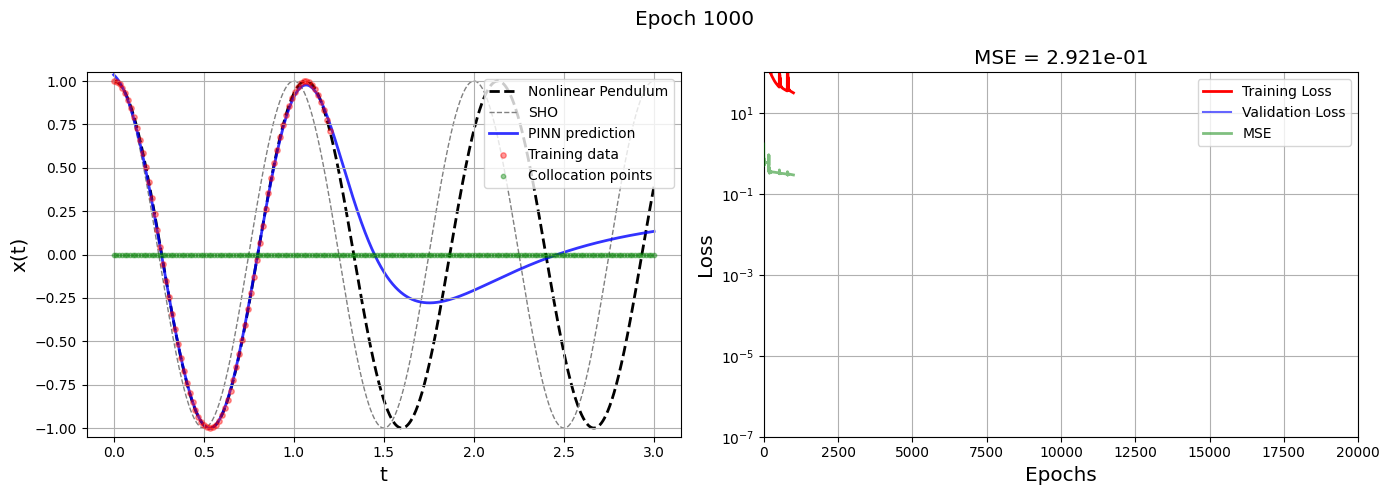

Epoch 1100: Val Loss = 2.8467e+03, period = 1.1720, NP Period = 1.0663, Learning rate = 9.0000e-03
Epoch 1200: Val Loss = 2.8735e+03, period = 1.1665, NP Period = 1.0663, Learning rate = 9.0000e-03
Epoch 1300: Val Loss = 2.7756e+03, period = 1.1617, NP Period = 1.0663, Learning rate = 9.0000e-03
Epoch 1400: Val Loss = 2.7367e+03, period = 1.1588, NP Period = 1.0663, Learning rate = 9.0000e-03
Epoch 1500: Val Loss = 2.6457e+03, period = 1.1510, NP Period = 1.0663, Learning rate = 9.0000e-03
Epoch 1600: Val Loss = 2.5273e+03, period = 1.1430, NP Period = 1.0663, Learning rate = 9.0000e-03
Epoch 1700: Val Loss = 2.6053e+03, period = 1.1456, NP Period = 1.0663, Learning rate = 9.0000e-03
Epoch 1800: Val Loss = 2.4754e+03, period = 1.1405, NP Period = 1.0663, Learning rate = 9.0000e-03
Epoch 1900: Val Loss = 2.3985e+03, period = 1.1337, NP Period = 1.0663, Learning rate = 9.0000e-03
Epoch 2000: Val Loss = 2.2098e+03, period = 1.1280, NP Period = 1.0663, Learning rate = 9.0000e-03
Epoch 2100

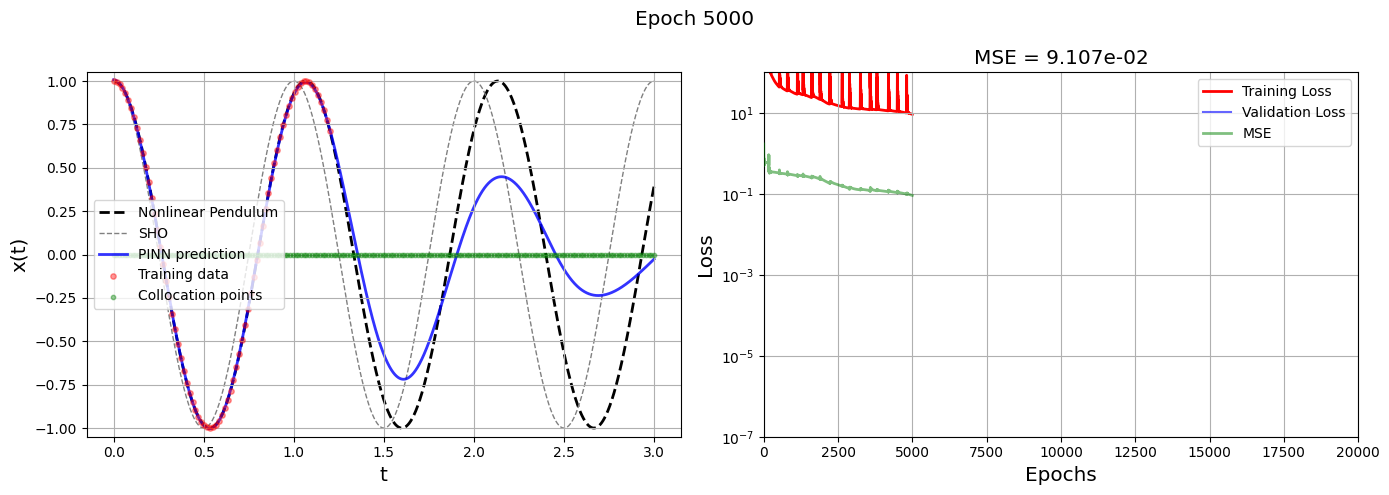

Epoch 5100: Val Loss = 8.6959e+02, period = 1.0850, NP Period = 1.0663, Learning rate = 5.9049e-03
Epoch 5200: Val Loss = 8.3753e+02, period = 1.0860, NP Period = 1.0663, Learning rate = 5.9049e-03
Epoch 5300: Val Loss = 7.6470e+02, period = 1.0832, NP Period = 1.0663, Learning rate = 5.9049e-03
Epoch 5400: Val Loss = 7.0000e+02, period = 1.0822, NP Period = 1.0663, Learning rate = 5.9049e-03
Epoch 5500: Val Loss = 6.8240e+02, period = 1.0841, NP Period = 1.0663, Learning rate = 5.9049e-03
Epoch 5600: Val Loss = 6.3066e+02, period = 1.0832, NP Period = 1.0663, Learning rate = 5.9049e-03
Epoch 5700: Val Loss = 6.0238e+02, period = 1.0832, NP Period = 1.0663, Learning rate = 5.9049e-03
Epoch 5800: Val Loss = 5.7271e+02, period = 1.0839, NP Period = 1.0663, Learning rate = 5.9049e-03
Epoch 5900: Val Loss = 5.4231e+02, period = 1.0839, NP Period = 1.0663, Learning rate = 5.9049e-03
Epoch 6000: Val Loss = 5.5024e+02, period = 1.0851, NP Period = 1.0663, Learning rate = 5.9049e-03
Epoch 6100

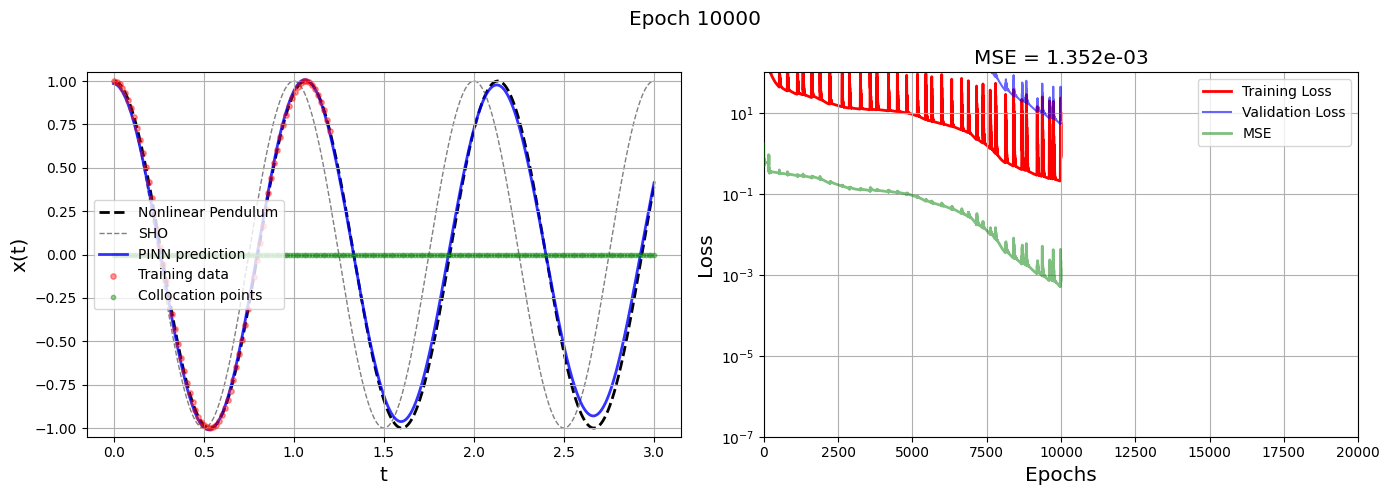

Epoch 10100: Val Loss = 5.1617e+00, period = 1.0660, NP Period = 1.0663, Learning rate = 3.4868e-03
Epoch 10200: Val Loss = 4.3945e+00, period = 1.0659, NP Period = 1.0663, Learning rate = 3.4868e-03
Epoch 10300: Val Loss = 5.2442e+00, period = 1.0660, NP Period = 1.0663, Learning rate = 3.4868e-03
Epoch 10400: Val Loss = 3.7981e+00, period = 1.0659, NP Period = 1.0663, Learning rate = 3.4868e-03
Epoch 10500: Val Loss = 3.1988e+00, period = 1.0658, NP Period = 1.0663, Learning rate = 3.4868e-03
Epoch 10600: Val Loss = 3.3586e+00, period = 1.0658, NP Period = 1.0663, Learning rate = 3.4868e-03
Epoch 10700: Val Loss = 3.4105e+00, period = 1.0658, NP Period = 1.0663, Learning rate = 3.4868e-03
Epoch 10800: Val Loss = 2.6711e+00, period = 1.0657, NP Period = 1.0663, Learning rate = 3.4868e-03
Epoch 10900: Val Loss = 2.6742e+00, period = 1.0658, NP Period = 1.0663, Learning rate = 3.4868e-03
Epoch 11000: Val Loss = 3.0107e+00, period = 1.0656, NP Period = 1.0663, Learning rate = 3.4868e-03


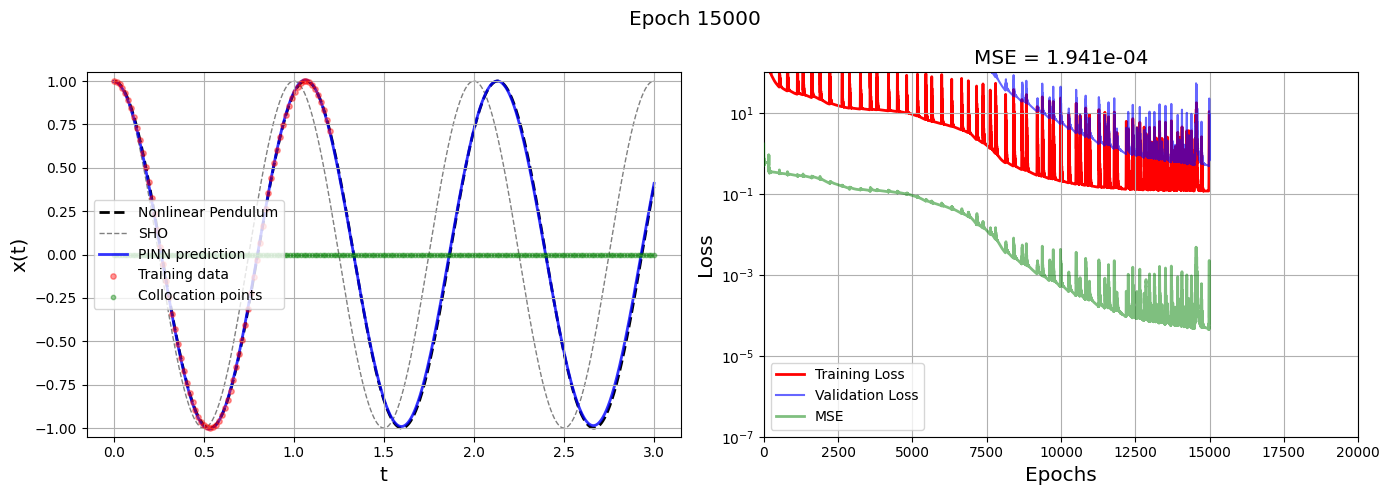

Epoch 15100: Val Loss = 5.1242e-01, period = 1.0656, NP Period = 1.0663, Learning rate = 2.8243e-03
Epoch 15200: Val Loss = 4.7843e-01, period = 1.0656, NP Period = 1.0663, Learning rate = 2.8243e-03
Epoch 15300: Val Loss = 1.2453e+00, period = 1.0657, NP Period = 1.0663, Learning rate = 2.8243e-03
Epoch 15400: Val Loss = 4.9247e-01, period = 1.0656, NP Period = 1.0663, Learning rate = 2.8243e-03
Epoch 15500: Val Loss = 5.1517e-01, period = 1.0655, NP Period = 1.0663, Learning rate = 2.8243e-03
Epoch 15600: Val Loss = 4.4944e-01, period = 1.0656, NP Period = 1.0663, Learning rate = 2.8243e-03
Epoch 15700: Val Loss = 4.7461e-01, period = 1.0655, NP Period = 1.0663, Learning rate = 2.8243e-03
Epoch 15800: Val Loss = 4.5330e-01, period = 1.0656, NP Period = 1.0663, Learning rate = 2.8243e-03
Epoch 15900: Val Loss = 1.1107e+01, period = 1.0656, NP Period = 1.0663, Learning rate = 2.8243e-03
Epoch 16000: Val Loss = 8.1650e-01, period = 1.0657, NP Period = 1.0663, Learning rate = 2.8243e-03


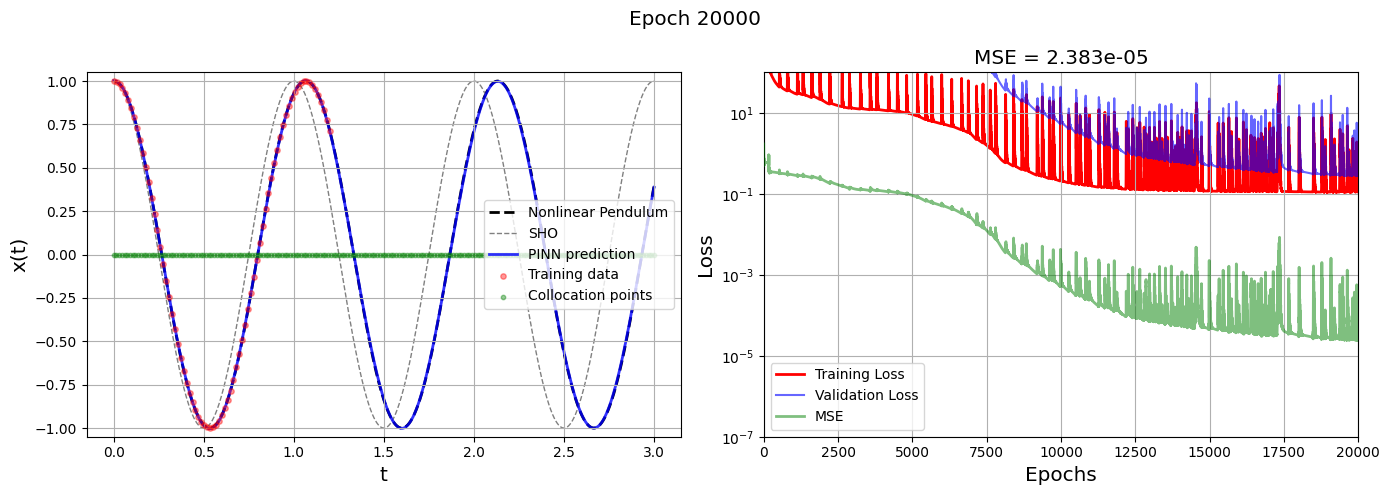

In [37]:
# PINN
PINN = FCN(1, 1, N_nodes, N_layers)

omega = torch.nn.Parameter(w0*torch.ones(1, requires_grad=True))

# Uses the Adam optimizer
optimizer = torch.optim.Adam(list(PINN.parameters())+[omega], lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=gamma, patience=patience, min_lr=1e-5, threshold=1e-4)

# Number of training steps
error_history           = []
training_loss_history   = []
validation_loss_history = []

omega_history = []
loss_val = torch.tensor(1.)

for i in range(epochs):
    # ===
    # Training
    # ===
    
    PINN.train()
    optimizer.zero_grad()
    
    # Compute data and derivative loss .........................
    u  = PINN(t_training)
    du = torch.autograd.grad(u, t_training, torch.ones_like(u), create_graph=True)[0]
    
    data_loss       = torch.mean((u  - x1_data)**2)
    derivative_loss = torch.mean((du - x2_data)**2)
    
    # Compute the ODE loss .........................
    
    z   = PINN(t_physics)
    dz  = torch.autograd.grad(z, t_physics, torch.ones_like(z), create_graph=True)[0]
    d2z = torch.autograd.grad(dz, t_physics, torch.ones_like(dz), create_graph=True)[0]
    
    # Linear Oscillator ODE with frequency as trainable parameter
    ode = d2z + z*omega**2
    ode_loss = torch.mean(ode**2)
    
    # Compute total loss
    loss = w_data*data_loss + w_derivative*derivative_loss + w_ode*ode_loss
    
    # Backpropagate the loss and update weights
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val.item())
    
    # ===
    # Validation
    # ===
    PINN.eval()

    v   = PINN(t_validation)
    dv  = torch.autograd.grad(v, t_validation, torch.ones_like(v), create_graph=True)[0]
    d2v = torch.autograd.grad(dv, t_validation, torch.ones_like(dv), create_graph=True)[0]
    
    data_loss_val       = torch.mean((v - x1_val)**2)
    derivative_loss_val = torch.mean((dv - x2_val)**2)
    ode_loss_val        = torch.mean((d2v + v*omega**2)**2)

    loss_val = w_data*data_loss_val + w_derivative*derivative_loss_val + w_ode*ode_loss_val
    
    # ===
    # Saving training information
    # ===
    p = PINN(t).detach()
    error = torch.mean((p - x1.view(-1,1))**2).item()
    
    error_history.append(error)
    training_loss_history.append(loss.item())
    validation_loss_history.append(loss_val.item())
    
    omega_history.append(omega.item())
    
    # ===
    # Plotting
    # ===
    if (i % 100) == 0: 
        print(f"Epoch {i}: Val Loss = {loss_val.item():.4e}, period = {(2*np.pi/omega.item()):.4f}, NP Period = {NP_Period:.4f}, Learning rate = {optimizer.param_groups[0]['lr']:.4e}")
        if any([i==epochs-1, i%5_000==0, i==1000]):
            plot_result()
            plt.show()


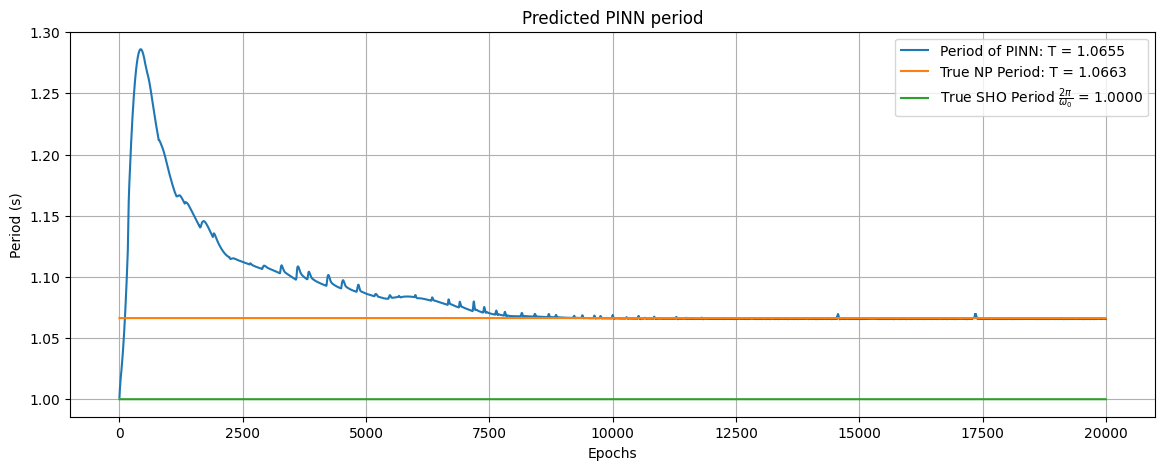

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot((2*np.pi)/np.array(omega_history), label=f"Period of PINN: T = {(2*np.pi)/omega.item():.4f}")
ax.plot(NP_Period*np.ones_like(omega_history), label=f"True NP Period: T = {NP_Period:.4f}")
ax.plot(SHO_Period*np.ones_like(omega_history), label="True SHO Period $\\frac{2\pi}{\omega_0}$" + f" = {SHO_Period:.4f}")

ax.grid()
ax.set_title("Predicted PINN period")
ax.set_ylabel("Period (s)")
ax.set_xlabel("Epochs")
plt.legend()
plt.savefig("plots/Period_comparison.png")
plt.show()

In [1]:
plot_result()
plt.savefig("plots/Comaprison_Linear.png")

NameError: name 'plot_result' is not defined